# Coin search by t-SNE via Tensorflow

https://github.com/despoisj/CoinsDataset

https://github.com/kylemcdonald/Parametric-t-SNE

https://github.com/gokceneraslan/tensorsne

https://github.com/zaburo-ch/Parametric-t-SNE-in-Keras/blob/master/mlp_param_tsne.py

https://github.com/danielfrg/tsne

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import clear_output
import pandas as pd
from scipy import spatial
from collections import defaultdict
import os
import cv2
import itertools
%matplotlib inline

## Datasets

In [2]:
def load_mnist_dataset(ndata):
    ds = input_data.read_data_sets('/tmp/MNIST_data', one_hot=True)
    return  (
        [28, 28, 1],
        len(ds.train.images) + len(ds.test.images),
        ds.train.images[:ndata],
        ds.train.labels[:ndata],
        ds.test.images[:ndata],
        ds.test.labels[:ndata])

def load_image_dataset(img_shape, path, ndata):
    w = img_shape[0]
    h = img_shape[1]
    c = img_shape[2]
    img_size = np.prod(img_shape)
    
    files  = os.listdir(path)[:2*ndata]
    file_num = len(files)
    assert file_num >= ndata, "%s %s" % (file_num, ndata)
    
    images = np.zeros([file_num, img_size])
    labels = np.zeros([file_num, 1])
    
    for i,f in enumerate(files):
        clear_output(True)
        print("%d: %s" % (i+1, f))

        f = os.path.join(path, f)
        img = cv2.imread(f) + .01
        if c == 1:
            img = np.max(img, axis=2)
        img = cv2.resize(img, (w,h), interpolation = cv2.INTER_CUBIC).astype('float32')
        norm = img.max()+.1
        img = img.astype('float32') / norm        
        images[i] = np.reshape(img, img_size)
        labels[i,0] = 1
    idx = list(range(file_num))
    np.random.shuffle(idx)
    images = images[idx]
    labels = labels[idx]
    clear_output(True)
    return (
        img_shape,
        file_num,
        images[:ndata],
        labels[:ndata],
        images[-ndata:],
        labels[-ndata:])

def load_stamps_dataset(ndata):
    return load_image_dataset(
        img_shape = [64, 64, 1],
        path      = "/netforge/datasets/common/document_parts/10000/stamp",
        ndata     = ndata)

def load_coins_dataset(ndata):
    return load_image_dataset(
        img_shape = [64, 64, 1],
        path      = "/netforge/datasets/private/roman/coins/images",
        ndata     = ndata)

## Load data

In [3]:
data_size = 6000
(
    image_shape, 
    file_num,
    train_images, 
    train_labels, 
    test_images, 
    test_labels
) = load_mnist_dataset(data_size)

print("File num   :", file_num)
print("Data size  :", data_size)
print("Train shape:", list(train_images.shape))
print("Test  shape:", list(test_images.shape))
print("Image shape:", image_shape)

Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
File num   : 65000
Data size  : 6000
Train shape: [6000, 784]
Test  shape: [6000, 784]
Image shape: [28, 28, 1]


## Visualisation

In [4]:
def show_images(images, image_shape, rows, cols):
    h = image_shape[0]
    w = image_shape[1]
    c = image_shape[2]

    n = rows*cols
    img = images[:n]
    img = np.reshape(img, [n*h, w])
    sheet = np.zeros([rows*h, cols*w])

    for i, j in itertools.product(range(rows), range(cols)):
        H = (i*cols+j) * h
        sheet[i*h:i*h+h, j*w:j*w+w] = img[H: H+h, 0:w]

    plt.figure(figsize = (15,7))
    plt.axis("off")
    plt.imshow(sheet, cmap='gray')
    plt.show()

Train images:


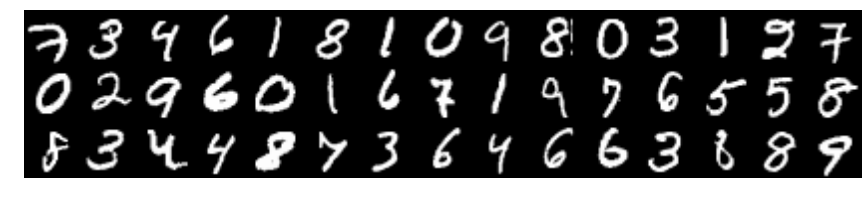

Test images:


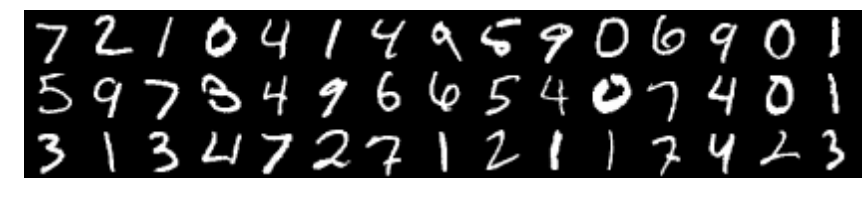

In [5]:
print("Train images:")
show_images(train_images, image_shape, rows=3, cols=15)
print("Test images:")
show_images(test_images, image_shape, rows=3, cols=15)

## Parametric t-SNE implementation
https://github.com/kylemcdonald/Parametric-t-SNE/blob/master/Parametric%20t-SNE%20(Keras).ipynb

In [6]:
def Hbeta(D, beta):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(np.multiply(D, P)) / sumP
    P = P / sumP
    return H, P

def x2p(X, u=15, tol=1e-4, print_iter=500, max_tries=50, verbose=0):
    # Initialize some variables
    n = X.shape[0]                     # number of instances
    P = np.zeros((n, n))               # empty probability matrix
    beta = np.ones(n)                  # empty precision vector
    logU = np.log(u)                   # log of perplexity (= entropy)
    
    # Compute pairwise distances
    if verbose > 0: print('Computing pairwise distances...')
    sum_X = np.sum(np.square(X), axis=1)
    # note: translating sum_X' from matlab to numpy means using reshape to add a dimension
    D = sum_X + sum_X[:,None] + -2 * X.dot(X.T)

    # Run over all datapoints
    if verbose > 0: print('Computing P-values...')
    for i in range(n):
        
        if verbose > 1 and print_iter and i % print_iter == 0:
            print('Computed P-values {} of {} datapoints...'.format(i, n))
        
        # Set minimum and maximum values for precision
        betamin = float('-inf')
        betamax = float('+inf')
        
        # Compute the Gaussian kernel and entropy for the current precision
        indices = np.concatenate((np.arange(0, i), np.arange(i + 1, n)))
        Di = D[i, indices]
        H, thisP = Hbeta(Di, beta[i])
        
        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while abs(Hdiff) > tol and tries < max_tries:
            
            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i]
                if np.isinf(betamax):
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i]
                if np.isinf(betamin):
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2
            
            # Recompute the values
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        
        # Set the final row of P
        P[i, indices] = thisP
        
    if verbose > 0: 
        print('Mean value of sigma: {}'.format(np.mean(np.sqrt(1 / beta))))
        print('Minimum value of sigma: {}'.format(np.min(np.sqrt(1 / beta))))
        print('Maximum value of sigma: {}'.format(np.max(np.sqrt(1 / beta))))
    
    return P, beta

def compute_joint_probabilities(samples, batch_size=5000, d=2, perplexity=30, tol=1e-5, verbose=0):
    v = d - 1
    
    # Initialize some variables
    n = samples.shape[0]
    batch_size = min(batch_size, n)
    
    # Precompute joint probabilities for all batches
    if verbose > 0: print('Precomputing P-values...')
    batch_count = int(n / batch_size)
    P = np.zeros((batch_count, batch_size, batch_size))
    for i, start in enumerate(range(0, n - batch_size + 1, batch_size)):   
        curX = samples[start:start+batch_size]                   # select batch
        P[i], beta = x2p(curX, perplexity, tol, verbose=verbose) # compute affinities using fixed perplexity
        P[i][np.isnan(P[i])] = 0                                 # make sure we don't have NaN's
        P[i] = (P[i] + P[i].T) # / 2                             # make symmetric
        P[i] = P[i] / P[i].sum()                                 # obtain estimation of joint probabilities
        P[i] = np.maximum(P[i], np.finfo(P[i].dtype).eps)

    return P

In [7]:
%%time
joint_probs = compute_joint_probabilities(train_images, batch_size=data_size, verbose=2)

Precomputing P-values...
Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 6000 datapoints...
Computed P-values 500 of 6000 datapoints...
Computed P-values 1000 of 6000 datapoints...
Computed P-values 1500 of 6000 datapoints...
Computed P-values 2000 of 6000 datapoints...
Computed P-values 2500 of 6000 datapoints...
Computed P-values 3000 of 6000 datapoints...
Computed P-values 3500 of 6000 datapoints...
Computed P-values 4000 of 6000 datapoints...
Computed P-values 4500 of 6000 datapoints...
Computed P-values 5000 of 6000 datapoints...
Computed P-values 5500 of 6000 datapoints...
Mean value of sigma: 2.1723964925535957
Minimum value of sigma: 1.037287706002322
Maximum value of sigma: 3.4826456994695683
CPU times: user 26.3 s, sys: 896 ms, total: 27.2 s
Wall time: 25.4 s


In [8]:
# P is the joint probabilities for this batch (Keras loss functions call this y_true)
# activations is the low-dimensional output (Keras loss functions call this y_pred)

def tsne_loss(P, batch_size, dims, activations):
    d = dims # TODO: should set this automatically, but the above is very slow for some reason
    n = batch_size # TODO: should set this automatically
    v = d - 1.
    eps = 10e-15 # needs to be at least 10e-8 to get anything after Q /= K.sum(Q)
    sum_act = tf.reduce_sum(tf.square(activations), axis=1)
    Q = tf.reshape(sum_act, [-1, 1]) + -2 * tf.matmul(activations, activations, transpose_b=True)
    Q = (sum_act + Q) / v
    Q = tf.pow(1 + Q, -(v + 1) / 2)
    Q *= (1 - tf.eye(n))
    Q /= tf.reduce_sum(Q)
    Q = tf.maximum(Q, eps)
    C = tf.log((P + eps) / (Q + eps))
    C = tf.reduce_mean(P * C) * 10000000
    return C

---
## TF Neural Networks

In [9]:
def conv2d_maxpool(inputs, filters, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
    l = tf.layers.conv2d(
        inputs=inputs,
        filters=filters,
        kernel_size=kernel_size,
        padding=padding,
        activation=tf.nn.relu)
    return tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)

def ConvNet(inputs, inp_shape, out_dim):
    l = tf.reshape(inputs, [-1,] + inp_shape)
    l = conv2d_maxpool(l, 16)
    l = conv2d_maxpool(l, 32)
    l = conv2d_maxpool(l, 64)
    l = conv2d_maxpool(l, 128)
    l = tf.contrib.layers.flatten(l)
    l = tf.layers.dense(l, units=300, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=out_dim)
    return l

### Graph

In [10]:
learning_rate = 1e-4
embed_dims    = 7

with tf.device('/gpu:0'):
    image_pl = tf.placeholder(dtype=tf.float32, shape=[data_size, np.prod(image_shape)], name='image_pl')
    embed_op = ConvNet(image_pl, image_shape, embed_dims)
    cost     = tsne_loss(joint_probs, data_size, embed_dims, embed_op)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### Train

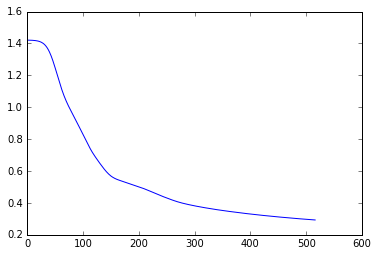

Step: 510/2000 [26%], Cost: 2.95e-01
CPU times: user 2min 1s, sys: 27.4 s, total: 2min 29s
Wall time: 2min 19s


In [11]:
%%time

train_steps = 2000

def plot_cost_trace(ct):
    plt.plot(ct)
    plt.show()

def get_train_batch(bs):
    idx = list(range(bs))
    np.random.shuffle(idx)
    return train_images[idx], train_labels[idx]
    
try:
    log_every   = 10
    costs       = []
    sess        = tf.Session()
    sess.run(tf.global_variables_initializer())
    for step in range(train_steps):
        _, c = sess.run([train_op, cost], feed_dict={image_pl : train_images})
        costs.append(c)

        if step%log_every == log_every - 1:
            clear_output(True)
            progress = "Step: %d/%d [%.0f%%], Cost: %.2e" % (step+1, train_steps, 100*(step+1)/train_steps, c)
            plot_cost_trace(costs)
except KeyboardInterrupt:
    pass

clear_output(True)
plot_cost_trace(costs)
print(progress)

### Find nearest

Data size: 6000 x 7


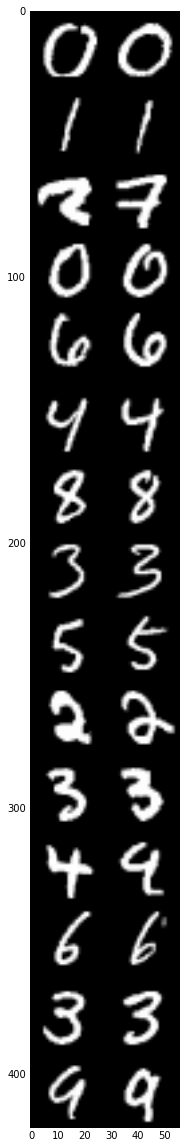

CPU times: user 968 ms, sys: 216 ms, total: 1.18 s
Wall time: 907 ms


In [18]:
%%time

def database():
    embeds = sess.run(embed_op, feed_dict = {image_pl : train_images})
    return train_images, embeds, train_labels

def targets(num):
    idx = list(range(len(test_images)))
    np.random.shuffle(idx)
    images = test_images[idx]
    labels = test_labels[idx]

    embeds = sess.run(embed_op, feed_dict = {image_pl : images})
    return images[:num], embeds[:num], labels[:num]

def label_argmax(labels):
    return np.argmax(labels, axis=1)

def find_nearest(targets, candidates):
    tree = spatial.KDTree(candidates)
    results = tree.query(targets)
    return results[1], results[0] 

def test_find_nearest_images(num):
    trg_img, trg_emb, trg_lbl = targets(num)
    dat_img, dat_emb, dat_lbl = database()

    nearests, distances = find_nearest(trg_emb, dat_emb)
    trg_lbl = label_argmax(trg_lbl)
    res_lbl = label_argmax(dat_lbl[nearests])
    res_img = dat_img[nearests]
    perf = np.sum(trg_lbl==res_lbl) / num

    print("Data size:", data_size, "x", embed_dims)
    
    img_1 = trg_img.reshape([num*image_shape[0],image_shape[1]])
    img_2 = res_img.reshape([num*image_shape[0],image_shape[1]])
    sheet = np.concatenate([img_1, img_2], axis=1)
    plt.figure(figsize = (60,20))
    plt.imshow(sheet, cmap='gray');
    plt.show()

        
test_find_nearest_images(15)

### EOF